<a href="https://colab.research.google.com/github/anubhavgupta1/Dive-Into-Deep-Learning/blob/main/Recurrent%20Neural%20Networks/Implementation%20from%20Scratch/mxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

     |████████████████████████████████| 81kB 5.9MB/s 
     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x65c64000 @  0x7f3b746ae615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
%matplotlib inline
from d2l import mxnet as d2l
import math
from mxnet import autograd, gluon, np, npx
npx.set_np()

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
len(vocab)

28

### Model Parameters

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=device)

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = np.zeros(num_hiddens, ctx=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

### RNN Model

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (np.zeros((batch_size, num_hiddens), ctx=device), )

In [7]:
def rnn(inputs, state, params):
    # Shape of `inputs`: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = np.tanh(np.dot(X, W_xh) + np.dot(H, W_hh) + b_h)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

In [8]:
class RNNModelScratch:  #@save
    """An RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = npx.one_hot(X.T, self.vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, ctx):
        return self.init_state(batch_size, self.num_hiddens, ctx)

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,init_rnn_state, rnn)

### Prediction

In [10]:
def predict(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, ctx=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: np.array([outputs[-1]], ctx=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [11]:
predict('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller iiiiiiiiii'

### Gradient Clipping

In [12]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, gluon.Block):
        params = [p.data() for p in net.collect_params().values()]
    else:
        params = net.params
    norm = math.sqrt(sum((p.grad ** 2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### Training

In [13]:
#@save
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], ctx=device)
        else:
            for s in state:
                s.detach()
        y = Y.T.reshape(-1)
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        with autograd.record():
            y_hat, state = net(X, state)
            l = loss(y_hat, y).mean()
        l.backward()
        grad_clipping(net, 1)
        updater(batch_size=1)  # Since the `mean` function has been invoked
        metric.add(l * y.size, y.size)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [14]:
#@save
def train(net, train_iter, vocab, lr, num_epochs, device,use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, gluon.Block):
        net.initialize(ctx=device, force_reinit=True,init=init.Normal(0.01))
        trainer = gluon.Trainer(net.collect_params(),'sgd', {'learning_rate': lr})
        updater = lambda batch_size: trainer.step(batch_size)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller ', 100, net, vocab, d2l.try_gpu()))

perplexity 1.0, 32354.3 tokens/sec on gpu(0)
time traveller with a slight accession ofcheerfulness really this is what is meant by the fourth dimensionthough so


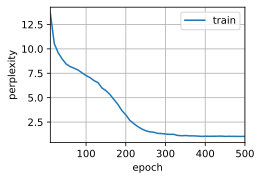

In [15]:
num_epochs, lr = 500, 1
train(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 1.4, 32335.5 tokens/sec on gpu(0)
time traveller held in his hand was a glitteringmetallic framework scarcely larger than a small clock and verydelic


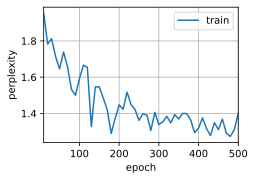

In [16]:
train(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),use_random_iter=True)